# Multivariate HMM with dimensionality reduction via dynamic factor model

### 1. necessary imports

In [27]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from hmmlearn.hmm import GaussianHMM

%matplotlib inline
sns.set_style("darkgrid")

### 2. load data

In [28]:
Z = pd.read_csv("data/macro_panel_standardized.csv", index_col=0, parse_dates=True)
dates = Z.index
Z

,gdp_yoy,inf_yoy,rate_3m_d1,rate_10y_d1,unemployment_d1
date,,,,,
1954-06-30,-2.263432,-1.030420,-0.410992,-0.224637,0.765015
1954-09-30,-1.557446,-1.291299,0.120248,-0.015858,0.243087
1954-12-31,-0.108478,-1.465614,0.183607,0.267484,-0.895664
1955-03-31,1.270170,-1.500869,0.281082,0.371874,-0.848216
1955-06-30,1.899856,-1.492280,0.363936,0.245115,-0.468632
...,...,...,...,...,...
2024-03-31,-0.037995,-0.115659,-0.089324,-0.642194,0.053295
2024-06-30,0.016863,-0.137507,-0.001596,0.617934,0.243087
2024-09-30,-0.112489,-0.327722,-0.386623,-1.126858,0.243087


### 3. fit 2-factor DFM
- **k_factors = 2**
- **factor_order = 1** gives each factor an AR(1) dynamic

In [29]:
mod_dfm = sm.tsa.DynamicFactor(
    Z,
    k_factors=2,
    factor_order=1,
    error_order=1,
)

res_dfm = mod_dfm.fit(maxiter=1000, disp=False)
res_dfm.summary()

C:\Users\Bram Bouma\locdev\markov-switching\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)


Dep. Variable:,"['gdp_yoy', 'inf_yoy', 'rate_3m_d1', 'rate_10y_d1', 'unemployment_d1']",No. Observations:,284
Model:,"DynamicFactor(factors=2, order=1)",Log Likelihood,-1355.010
,+ AR(1) errors,AIC,2758.020
Date:,"Sun, 18 May 2025",BIC,2845.595
Time:,18:07:55,HQIC,2793.131
Sample:,06-30-1954,,
,- 03-31-2025,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"7.93, 48.57, 1.70, 0.27, 0.18",Jarque-Bera (JB):,"1510.44, 77.43, 3087.03, 165.58, 107845.38"
Prob(Q):,"0.00, 0.00, 0.19, 0.60, 0.67",Prob(JB):,"0.00, 0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"1.28, 1.86, 0.53, 2.64, 9.25",Skew:,"-0.06, 0.04, 0.07, -0.29, 5.88"


### 4. extract smoothed factors

In [30]:
factors = res_dfm.factors.smoothed
F = pd.DataFrame(
    factors.T,
    index=dates,
    columns=["Factor1", "Factor2"]
)
F.head()

,Factor1,Factor2
date,,
1954-06-30,-1.799800,3.254212
1954-09-30,-1.137799,2.312419
1954-12-31,0.162320,0.336852
1955-03-31,1.213536,-1.678048
1955-06-30,1.580473,-2.680712


<Axes: xlabel='date'>

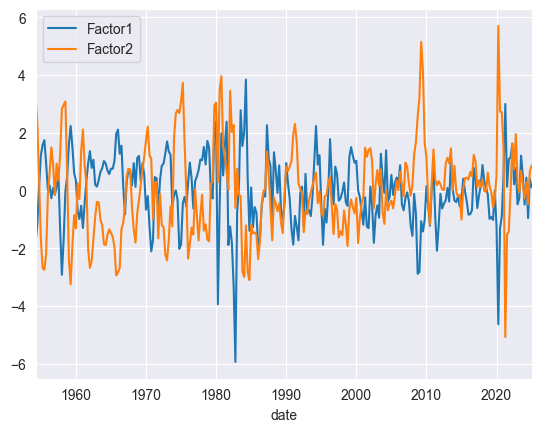

In [31]:
F.plot()

### 5. check variance explained by factors

In [32]:
common_var = (res_dfm.fittedvalues.var()).mean()
total_var = Z.var().mean()

print(f"common component explains ~= {common_var/total_var: 0.1%}")

common component explains ~=  36.5%


### 6. grid search regime count same as previous two models

In [33]:
results = []
for k in range(1, 5):
    hmm = GaussianHMM(
        n_components=k,
        covariance_type="full",
        n_iter=1000,
        random_state=42,
        verbose=False
    )

    hmm.fit(F.values)
    logL = hmm.score(F.values)
    bic = hmm.bic(F.values)
    aic = hmm.aic(F.values)
    results.append((k, logL, bic, aic, hmm))

    print(f"k={k}  logL={logL:,.1f}  AIC={aic:,.1f}  BIC={bic:,.1f}")

best_k, _, _, _, best_hmm = min(results, key=lambda t: t[2])
print(f"\nSelected k = {best_k}")


k=1  logL=-954.2  AIC=1,918.3  BIC=1,936.5
k=2  logL=-895.3  AIC=1,816.7  BIC=1,864.1
k=3  logL=-894.8  AIC=1,835.6  BIC=1,919.6
k=4  logL=-811.8  AIC=1,693.7  BIC=1,821.4

Selected k = 4


this time 4 regimes had the best LL, AIC, and BIC so I guess we'll try 4 regimes even though it's a lot harder to come up with an underlying, intuitive macroeconomic story which 4 regimes

In [34]:
# just in case I do want to go with 3 regimes still
# best_k, _, _, _, best_hmm = results[2]
# print(best_k)

### 7. smoothed regime posterior probabilities

Text(0.5, 1.0, 'Regime probabilities (DFM-HMM)')

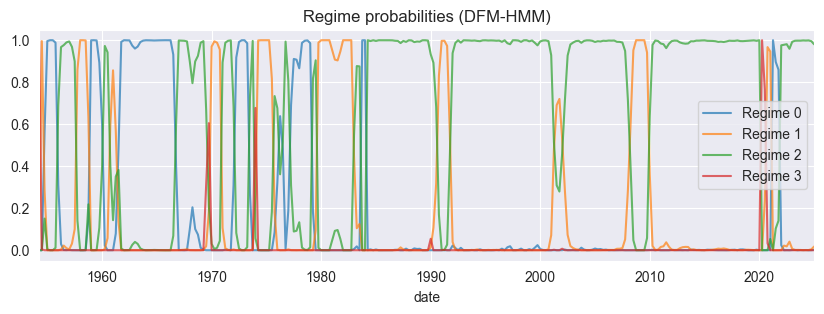

In [35]:
gamma_dfm = pd.DataFrame(
    best_hmm.predict_proba(F.values),
    index=dates,
    columns=[f"Regime {s}" for s in range(best_k)]
)

gamma_dfm.plot(figsize=(10, 3), alpha=0.7)
plt.title("Regime probabilities (DFM-HMM)")

**overlay on GDP**

In [36]:
gdp = pd.read_csv("data/macro_panel.csv", index_col=0, parse_dates=True)["gdp_yoy"]
gdp.head()

date
1954-06-30    -9.835032
1954-09-30    -3.085192
1954-12-31    10.768225
1955-03-31    23.949307
1955-06-30    29.969666
Name: gdp_yoy, dtype: float64

Text(0.5, 1.0, 'GDP YoY with DFM-HMM regimes')

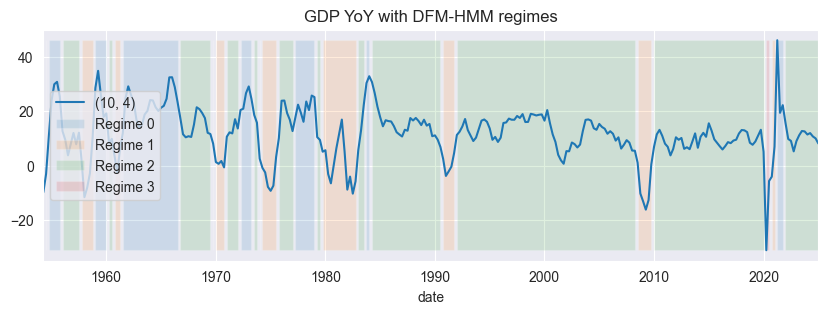

In [37]:
state_dfm = best_hmm.predict(F.values)

fig, ax = plt.subplots(figsize=(10, 3))
gdp.plot(ax=ax, label=(10,4))
for s in range(best_k):
    ax.fill_between(
        gdp.index,
        gdp.min(),
        gdp.max(),
        where=(state_dfm==s),
        alpha=0.15,
        label=f"Regime {s}"
    )
ax.legend()
ax.set_title("GDP YoY with DFM-HMM regimes")

### 8. factor loadings and regime-specific covariance in 5-var space

In [38]:
# loadings
Lambda = res_dfm.params.iloc[:len(Z.columns) * 2].values.reshape(len(Z.columns), 2)
load_df = pd.DataFrame(Lambda, index=Z.columns, columns=["F1", "F2"])
display(load_df.style.format("{:+.2f}"))

# covariance
Psi = np.diag(res_dfm.filter_results.obs_cov.shape[0]*[0.])
for r in range(best_k):
    Sigma_f = best_hmm.covars_[r]
    Sigma_hat = Lambda @ Sigma_f @ Lambda.T + Psi
    print(f"\nRegime {r} covariance:")
    display(pd.DataFrame(Sigma_hat, index=Z.columns, columns=Z.columns).round(3).style.background_gradient(cmap="viridis"))

,F1,F2
gdp_yoy,+0.36,-0.50
inf_yoy,+0.02,-0.01
rate_3m_d1,+0.59,+0.15
rate_10y_d1,+0.87,+0.42
unemployment_d1,-0.27,+0.15



Regime 0 covariance:


,gdp_yoy,inf_yoy,rate_3m_d1,rate_10y_d1,unemployment_d1
gdp_yoy,0.440000,0.012000,0.121000,0.062000,-0.195000
inf_yoy,0.012000,0.000000,0.004000,0.002000,-0.005000
rate_3m_d1,0.121000,0.004000,0.066000,0.072000,-0.061000
rate_10y_d1,0.062000,0.002000,0.072000,0.100000,-0.040000
unemployment_d1,-0.195000,-0.005000,-0.061000,-0.040000,0.088000



Regime 1 covariance:


,gdp_yoy,inf_yoy,rate_3m_d1,rate_10y_d1,unemployment_d1
gdp_yoy,0.554000,0.017000,0.330000,0.374000,-0.287000
inf_yoy,0.017000,0.001000,0.019000,0.026000,-0.011000
rate_3m_d1,0.330000,0.019000,0.925000,1.437000,-0.339000
rate_10y_d1,0.374000,0.026000,1.437000,2.277000,-0.475000
unemployment_d1,-0.287000,-0.011000,-0.339000,-0.475000,0.187000



Regime 2 covariance:


,gdp_yoy,inf_yoy,rate_3m_d1,rate_10y_d1,unemployment_d1
gdp_yoy,0.234000,0.006000,0.066000,0.035000,-0.104000
inf_yoy,0.006000,0.000000,0.006000,0.007000,-0.004000
rate_3m_d1,0.066000,0.006000,0.325000,0.522000,-0.100000
rate_10y_d1,0.035000,0.007000,0.522000,0.859000,-0.134000
unemployment_d1,-0.104000,-0.004000,-0.100000,-0.134000,0.063000



Regime 3 covariance:


,gdp_yoy,inf_yoy,rate_3m_d1,rate_10y_d1,unemployment_d1
gdp_yoy,2.254000,0.069000,1.286000,1.427000,-1.152000
inf_yoy,0.069000,0.002000,0.040000,0.044000,-0.035000
rate_3m_d1,1.286000,0.040000,0.735000,0.817000,-0.658000
rate_10y_d1,1.427000,0.044000,0.817000,0.909000,-0.730000
unemployment_d1,-1.152000,-0.035000,-0.658000,-0.730000,0.589000


**interpretation:**
- factor 1 loads positively on GDP growth and negatively on unemployment (can be iterpreted as a "growth factor")
- opposite is true of factor 2
- interestingly they both have same loading on yield curve slope (I guess I should probably use market priced yields instead?) idk how much those interest rate variables are really doing
- if we interpret regime 3 as a 'recessionary' regime (see the above plot of regimes overlayed onto gdp growth), you can see that covariance between unemployment and GDP growth get much more strongy *negative* in times of recessions. I guess that makes sense?
    - also, the variances of every variable (except the interest rates) goes up quite a bit in regime 3 and interest rate covariance with everything (aside from unemployment) goes up (going down for covariance with unemployment)

### 9. transition matrix and expected duration

In [39]:
print("transition matrix:")
display(pd.DataFrame(
    best_hmm.transmat_,
    index=[f"Regime {i}" for i in range(best_k)],
    columns=[f"Regime {i}" for i in range(best_k)]
).round(3))

dur_dfm = 1 / (1 - np.diag(best_hmm.transmat_))
print(pd.Series(dur_dfm, index=[f"Regime {i}" for i in range(best_k)]).round(1).rename("Expected duration (quarters)"))

transition matrix:


,Regime 0,Regime 1,Regime 2,Regime 3
Regime 0,0.836,0.000,0.164,0.000
Regime 1,0.070,0.796,0.134,0.000
Regime 2,0.027,0.038,0.922,0.014
Regime 3,0.000,0.767,0.000,0.233


Regime 0     6.1
Regime 1     4.9
Regime 2    12.8
Regime 3     1.3
Name: Expected duration (quarters), dtype: float64


**interpretation:**
- I'm still skeptical about the k=4 regimes, you can see that regime 3 has an expected duration of 1.3 quarters and has very low state persistence (looking at the transition probabilities)
- again maybe an MS-VAR model is better suited for fitting onto dynamic factors. Or maybe just simplify it and force 2 regimes instead of automatically picking based on best AIC/BIC

**convergence trace:**

Text(0, 0.5, 'Log-L')

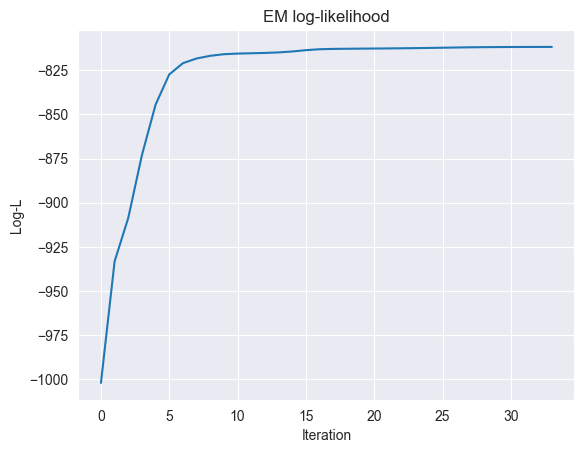

In [40]:
plt.plot(best_hmm.monitor_.history)
plt.title("EM log-likelihood")
plt.xlabel("Iteration")
plt.ylabel("Log-L")